## Paso 1: Entendimiento del problema

Queremos ayudar a:
- Propietarios de alojamientos en Airbnb a fijar precios más competitivos.
- Inversores a identificar apartamentos infravalorados respecto al mercado.

Objetivo: predecir el precio adecuado de un alojamiento en Madrid y detectar listados con precio por debajo del estimado.

---

## Paso 2: Carga de datos y limpieza inicial

- Fuente: Inside Airbnb – Madrid
- Datos iniciales: ~25.000 registros
- Datos tras limpieza: ~19.000 registros
- Eliminamos registros sin precio o con valores incoherentes.

---

In [1]:
# Librerías estándar
import pandas as pd
import numpy as np
import folium

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from src.utils.toolbox import *


# Modelado
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib

In [2]:
# Cargar el archivo de Madrid
df_madrid = pd.read_csv('listings_mad.csv', low_memory=False)

# Ver tamaño y primeras columnas
print(df_madrid.shape)
df_madrid.head()

(25288, 18)


id                                          name  host_id host_name  \
0  21853                          Bright and airy room    83531     Abdel   
1  30320                   Great Vacational Apartments   130907      Dana   
2  30959               Beautiful loft in Madrid Center   132883    Angela   
3  40916               Holiday Apartment Madrid Center   130907      Dana   
4  62423  MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID   303845    Arturo   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0              Latina      Cármenes  40.40381   -3.74130     Private room   
1              Centro           Sol  40.41476   -3.70418  Entire home/apt   
2              Centro   Embajadores  40.41259   -3.70105  Entire home/apt   
3              Centro   Universidad  40.42247   -3.70577  Entire home/apt   
4              Centro      Justicia  40.41884   -3.69655     Private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0   29.0               4                 33  2018-07-15               0.26   
1    NaN               5                172  2022-09-26               0.96   
2    NaN               3                  8  2017-05-30               0.07   
3    NaN               5                 49  2021-12-11               0.28   
4   77.0               1                227  2025-02-20               2.73   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                               2               233                      0   
1                               3                 0                      0   
2                               1                 0                      0   
3                               3                 0                      0   
4                               3               298                     46   

  license  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [3]:
df_madrid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25288 entries, 0 to 25287
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25288 non-null  int64  
 1   name                            25288 non-null  object 
 2   host_id                         25288 non-null  int64  
 3   host_name                       25269 non-null  object 
 4   neighbourhood_group             25288 non-null  object 
 5   neighbourhood                   25288 non-null  object 
 6   latitude                        25288 non-null  float64
 7   longitude                       25288 non-null  float64
 8   room_type                       25288 non-null  object 
 9   price                           19274 non-null  float64
 10  minimum_nights                  25288 non-null  int64  
 11  number_of_reviews               25288 non-null  int64  
 12  last_review                     

## Paso 3: Análisis exploratorio (MiniEDA)

- Distribución del target (`price`) → muy sesgada (asimetría a la derecha)
- Visualización de precios por barrio y tipo de alojamiento
- Aplicación de `log(price)` y filtro de outliers en distintas versiones (<1000 €, <800 €, <500 €)

In [4]:
# Mini EDA: comprobar nulos y estadísticos básicos de la variable precio
df_madrid['price'].isnull().sum(), df_madrid['price'].describe()


(np.int64(6014),
 count    19274.000000
 mean       138.965082
 std        433.623184
 min          8.000000
 25%         65.000000
 50%         97.000000
 75%        142.000000
 max      23124.000000
 Name: price, dtype: float64)

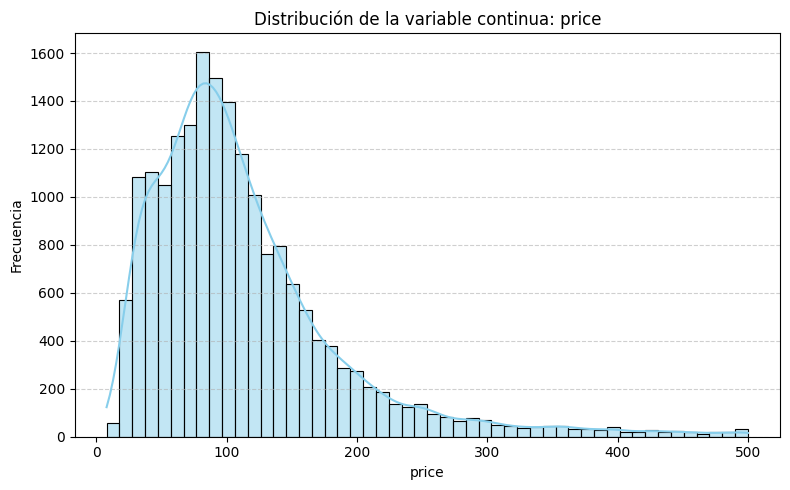

In [5]:
# Eliminar filas con valores nulos en la columna 'price'
df_madrid = df_madrid[df_madrid["price"].notnull()]

# Imputar los valores nulos de 'reviews_per_month' con 0
df_madrid["reviews_per_month"] = df_madrid["reviews_per_month"].fillna(0)

# Eliminar columnas innecesarias
df_madrid = df_madrid.drop(columns=["last_review", "license", "name", "host_name"])

# Reindexar utilizando la columna 'id'
df_madrid = df_madrid.set_index("id")

# Filtrar valores extremos para representar la variable 'price'
df_price_clean = df_madrid[df_madrid["price"] <= 500]
plot_target_distribution_continuous(df_price_clean, "price", bins=50)

Claramente hay outliers que distorisionan la distribución. Más del 75% de los precios están por debajo de 142€, pero hay un pequeño nº con precios altísimos.

In [6]:
descripcion_variables(df_madrid)


🔹 Variable: host_id
Tipo: int64
Tipo inferido: Numérica continua
Media: 275104932.45
Desviación estándar: 211792648.34
Mínimo: 7952
Máximo: 682175911

🔹 Variable: neighbourhood_group
Tipo: object
Tipo inferido: Categórica
Valores únicos: 21
Más frecuente: Centro (8298 veces)

🔹 Variable: neighbourhood
Tipo: object
Tipo inferido: Categórica
Valores únicos: 128
Más frecuente: Embajadores (2177 veces)

🔹 Variable: latitude
Tipo: float64
Tipo inferido: Numérica continua
Media: 40.42
Desviación estándar: 0.02
Mínimo: 40.3314
Máximo: 40.57729

🔹 Variable: longitude
Tipo: float64
Tipo inferido: Numérica continua
Media: -3.69
Desviación estándar: 0.03
Mínimo: -3.88399
Máximo: -3.5459040932605648

🔹 Variable: room_type
Tipo: object
Tipo inferido: Categórica
Valores únicos: 4
Más frecuente: Entire home/apt (13871 veces)

🔹 Variable: price
Tipo: float64
Tipo inferido: Numérica continua
Media: 138.97
Desviación estándar: 433.62
Mínimo: 8.0
Máximo: 23124.0

🔹 Variable: minimum_nights
Tipo: int64
T

In [7]:
describe_df(df_madrid)

host_id neighbourhood_group neighbourhood latitude  \
Tipo                int64              object        object  float64   
% Nulos             0.00%               0.00%         0.00%    0.00%   
Valores infinitos      No                  No            No       No   
Valores Únicos       7904                  21           128    13245   
% Cardinalidad     41.01%               0.11%         0.66%   68.72%   

                  longitude room_type    price minimum_nights  \
Tipo                float64    object  float64          int64   
% Nulos               0.00%     0.00%    0.00%          0.00%   
Valores infinitos        No        No       No             No   
Valores Únicos        12778         4      665             70   
% Cardinalidad       66.30%     0.02%    3.45%          0.36%   

                  number_of_reviews reviews_per_month  \
Tipo                          int64           float64   
% Nulos                       0.00%             0.00%   
Valores infinitos                No                No   
Valores Únicos                  585               956   
% Cardinalidad                3.04%             4.96%   

                  calculated_host_listings_count availability_365  \
Tipo                                       int64            int64   
% Nulos                                    0.00%            0.00%   
Valores infinitos                             No               No   
Valores Únicos                                72              366   
% Cardinalidad                             0.37%            1.90%   

                  number_of_reviews_ltm  
Tipo                              int64  
% Nulos                           0.00%  
Valores infinitos                    No  
Valores Únicos                      159  
% Cardinalidad                    0.82%

c:\Users\sanlo\bootcampds\ONLINE_DS_THEBRIDGE_SANLOGLEZ\Project_Break_II_ML_Airbnb_investment\src\utils\toolbox.py:489: UserWarning: Columna target price tiene poca cardinalidad (3.45%).
  warnings.warn(f"Columna target {target_col} tiene poca cardinalidad ({cardinalidad_target:.2f}%).")


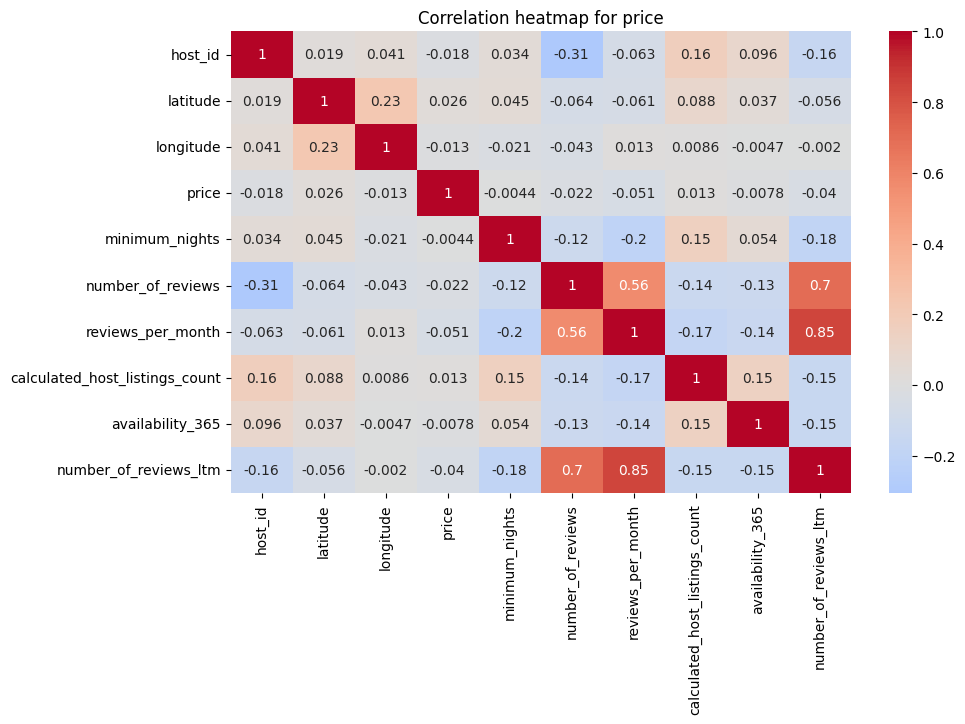

Variables numéricas más correlacionadas con el precio: []


In [8]:
# Variables numéricas correlacionadas con el precio
features_num = get_features_num_regression(df_madrid, target_col="price", umbral_corr=0.1, pvalue=0.05, mostrar=True)
print("Variables numéricas más correlacionadas con el precio:", features_num)

Ninguna variable supera una correlación absoluta de 0.1, lo cual indica que no hay fuertes relaciones lineales individuales con el precio.

In [9]:
# Variables categóricas relacionadas con price
features_cat = get_features_cat_regression(
    df_madrid,
    target_col="price",
    pvalue=0.05
)
print("Variables categóricas significativamente relacionadas con el precio:\n", features_cat)

❌ La variable 'price' no tiene suficiente cardinalidad para considerarse continua.
Cardinalidad única: 665 (3.45%)
Variables categóricas significativamente relacionadas con el precio:
 None


La variable price tiene solo 665 valores únicos sobre 19.274 filas, es decir, un 3.45% de cardinalidad relativa, y la función lo considera insuficiente para un análisis robusto ANOVA.

Peeeero… eso es demasiado estricto, porque price sí es una variable continua de facto.

Vamos a probar forzando el análisis categórico bajando al 3%

In [10]:
# Evaluar relación entre variables categóricas y el precio (versión flexible)
features_cat = get_features_cat_regression_flexible(
    df_madrid,
    target_col="price",
    pvalue=0.05
)
print("Variables categóricas relacionadas con el precio (versión flexible):\n", features_cat)

Variables categóricas relacionadas con el precio (versión flexible):
 ['neighbourhood_group', 'room_type']


- room_type → muy relevante (entero vs. compartido, etc.)
- neighbourhood_group → también esperable (zona central más cara)

Curiosamente neighbourhood no sale como significativa globalmente, seguramente por su alta cardinalidad (128 barrios), lo que diluye el efecto global en ANOVA. Pero podríamos seguir usándola en el modelo con codificación, ya que puede contener información útil si se combina con otras variables.

In [11]:
# Lista final de variables predictoras seleccionadas
variables_numericas = [
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'number_of_reviews_ltm'
]

variables_categoricas = [
    'room_type',
    'neighbourhood_group',
    'neighbourhood'  # incluida aunque no salió significativa
]

Variables seleccionadas como predictoras
🔹 Variables numéricas (aunque débilmente correlacionadas):
- minimum_nights
- number_of_reviews
- reviews_per_month
- calculated_host_listings_count
- availability_365
- number_of_reviews_ltm

Estas no tienen alta correlación individual, pero pueden aportar información en conjunto al modelo.

🔹 Variables categóricas (con relación significativa según ANOVA):
- room_type
- neighbourhood_group

Estas mostraron diferencias significativas de precio entre grupos.

🔸 Variables adicionales consideradas útiles:
- neighbourhood → Alta cardinalidad (128), pero tiene sentido mantenerla para el modelo (puede capturar diferencias locales de precio). Codificaremos como OneHot.

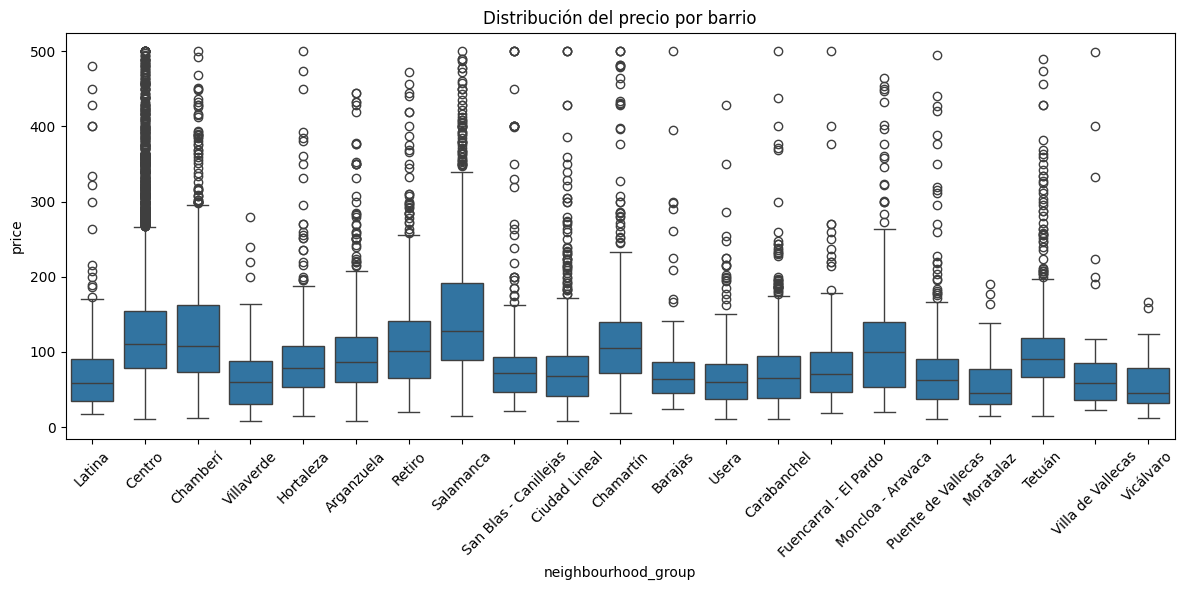

In [12]:
# Boxplot precio por barrio
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_price_clean, x="neighbourhood_group", y="price")
plt.xticks(rotation=45)
plt.title("Distribución del precio por barrio")
plt.tight_layout()
plt.show()

Al eliminar los precios extremos (filtrando por valores menores o iguales a 500 €), la distribución del precio por grupo de barrio se visualiza de forma más clara.

Se observan diferencias notables entre zonas: barrios como Centro, Salamanca o Retiro presentan medianas más altas que otras zonas como Usera, Villa de Vallecas o Vicálvaro.

La dispersión dentro de algunos barrios es significativa, lo que sugiere que hay bastante heterogeneidad incluso dentro de una misma zona.

Esta variable (neighbourhood_group) aporta información relevante y será útil como predictora en el modelo.

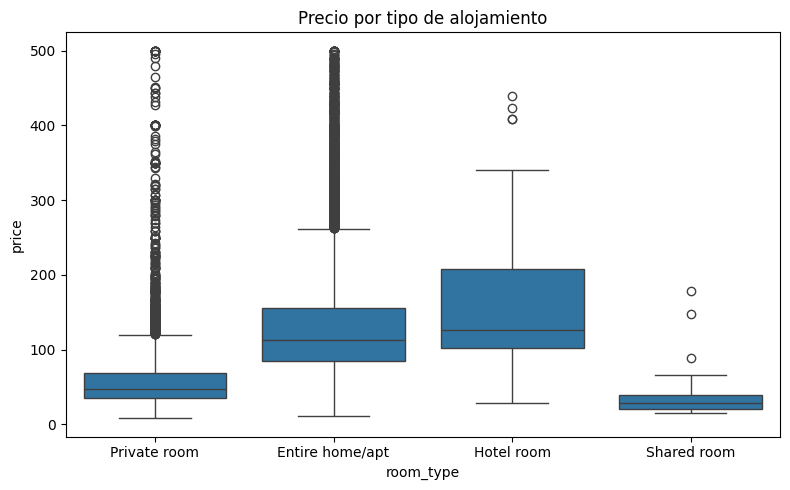

In [13]:
# Boxplot precio tipo de alojamiento
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_price_clean, x="room_type", y="price")
plt.title("Precio por tipo de alojamiento")
plt.tight_layout()
plt.show()

Como era de esperar, los alojamientos enteros presentan un precio promedio mucho más alto que las habitaciones privadas o compartidas. Esta variable muestra una clara relación con el precio y tiene valor predictivo evidente, por lo que se incluirá en el modelo.

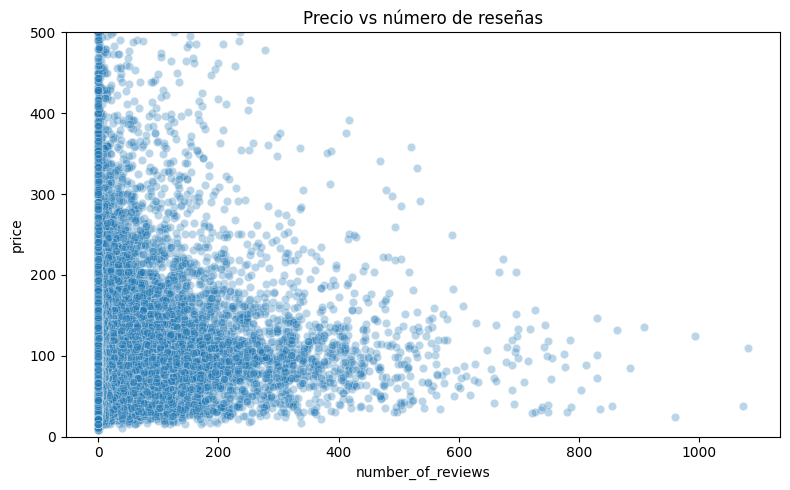

In [14]:
# Scatterplot: número de reseñas vs precio
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_price_clean, x="number_of_reviews", y="price", alpha=0.3)
plt.ylim(0,500)
plt.title("Precio vs número de reseñas")
plt.tight_layout()
plt.show()

Se observa una concentración de precios más bajos en los alojamientos con mayor número de reseñas. Esto puede deberse a que precios competitivos atraen más clientes, mientras que los alojamientos muy caros tienen menos rotación. Aunque la relación no es lineal, el número de reseñas podría actuar como indicador indirecto de accesibilidad o popularidad.

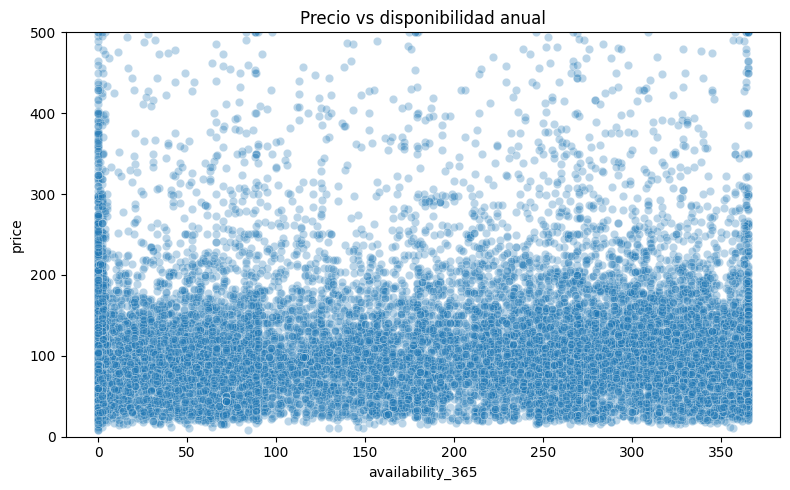

In [15]:
#Scatterplot: disponibilidad vs precio
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_price_clean, x="availability_365", y="price", alpha=0.3)
plt.ylim(0, 500)
plt.title("Precio vs disponibilidad anual")
plt.tight_layout()
plt.show()

La relación entre precio y disponibilidad anual no es lineal, pero parece indicar que los alojamientos con disponibilidad total o casi nula tienden a tener precios más extremos. Esta variable podría actuar como un proxy del tipo de uso del alojamiento (uso turístico intensivo vs. puntual o premium)

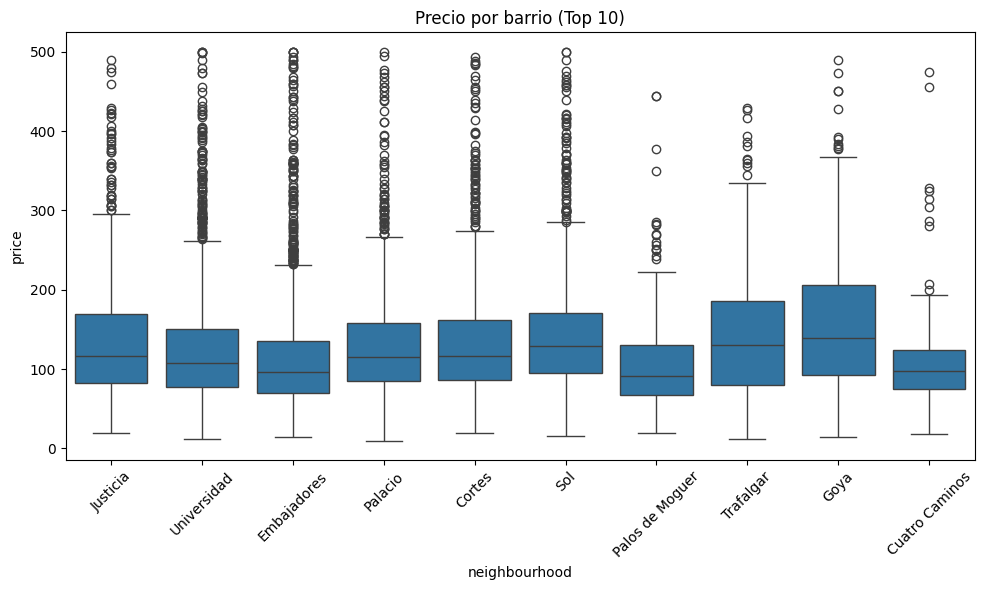

In [16]:
#Boxplot o barplot por neighbourhood (top 10 más frecuentes)
top10 = df_price_clean['neighbourhood'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_price_clean[df_price_clean['neighbourhood'].isin(top10)],
            x='neighbourhood', y='price')
plt.xticks(rotation=45)
plt.title("Precio por barrio (Top 10)")
plt.tight_layout()
plt.show()

Este análisis muestra que incluso dentro de los barrios más frecuentes en la muestra, el precio varía ampliamente. Esto refuerza la utilidad de construir un modelo que estime el ‘precio justo’ según múltiples factores, y no solo por ubicación.

Vamos a tratar las variables categóricas y numéricas

---

## Paso 4: Ingeniería de variables

- Conversión de variables categóricas con `get_dummies()`
- Transformación logarítmica de `price`
- Filtros por outliers

---

In [17]:
# Codificar las variables categóricas
df_madrid_encoded = pd.get_dummies(df_madrid, columns=variables_categoricas, drop_first=True)

In [18]:
# Separamos x e y
X = df_madrid_encoded.drop(columns=["price"])
y = df_madrid_encoded["price"]

In [19]:
# Escalar variables numéricas
scaler = StandardScaler()
X[variables_numericas] = scaler.fit_transform(X[variables_numericas])

---

## Paso 5: División de datos

- División 80/20: `train_test_split()`

---

In [20]:
# Separamos Train  y Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
# Guardamos copias
import os
os.makedirs("src/data_sample", exist_ok=True)

X_train.to_csv("src/data_sample/X_train.csv", index=True)
X_test.to_csv("src/data_sample/X_test.csv", index=True)
y_train.to_csv("src/data_sample/y_train.csv", index=True)
y_test.to_csv("src/data_sample/y_test.csv", index=True)


---

## Paso 6: Entrenamiento de modelos

Modelos entrenados:
- Random Forest Regressor (baseline y ajustado)
- XGBoost Regressor

Proceso:
- Entrenamiento con datos filtrados y log-transformados
- Evaluación con MAE, RMSE, R²

---

In [22]:
# Entrenamos RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
# Entrenamos XGBRegressor
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
# Validación cruzada (RMSE)
rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
xgb_cv = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("RMSE CV (Random Forest):", -rf_cv.mean())
print("RMSE CV (XGBoost)      :", -xgb_cv.mean())

RMSE CV (Random Forest): 473.77026098993247
RMSE CV (XGBoost)      : 492.0438717831229


In [25]:
# Evaluación sobre test
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

---

## Paso 7: Comparación de resultados

Ejemplo:
- Sin filtrar:  
  MAE = 65.84 € / RMSE = 209.09 € / R² = -0.02

- Con log(price) + filtro < 500 €:  
  MAE = 33.84 € / RMSE = 57.38 € / R² = 0.37

---

In [26]:
def mostrar_metricas(y_true, y_pred, modelo):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\nResultados para {modelo}")
    print(f"MAE  : {mae:.2f} €")
    print(f"RMSE : {rmse:.2f} €")
    print(f"R²   : {r2:.4f}")
    print("-" * 40)

mostrar_metricas(y_test, y_pred_rf, "Random Forest")
mostrar_metricas(y_test, y_pred_xgb, "XGBoost")


Resultados para Random Forest
MAE  : 65.84 €
RMSE : 209.08 €
R²   : -0.0223
----------------------------------------

Resultados para XGBoost
MAE  : 73.36 €
RMSE : 217.84 €
R²   : -0.1097
----------------------------------------


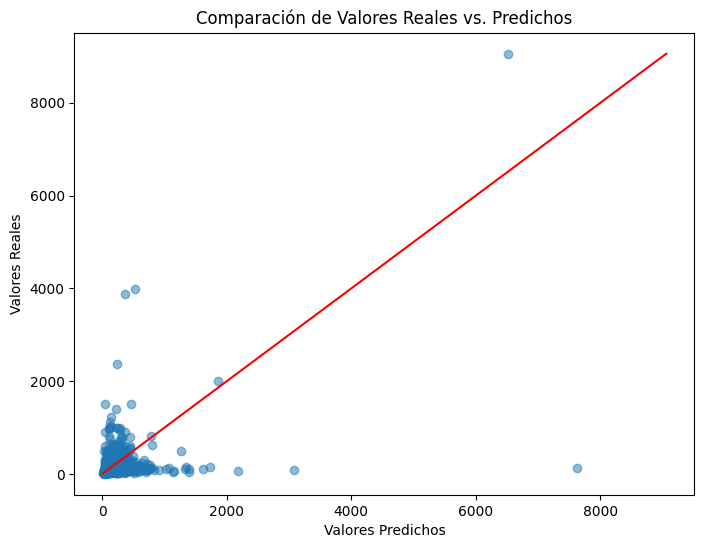

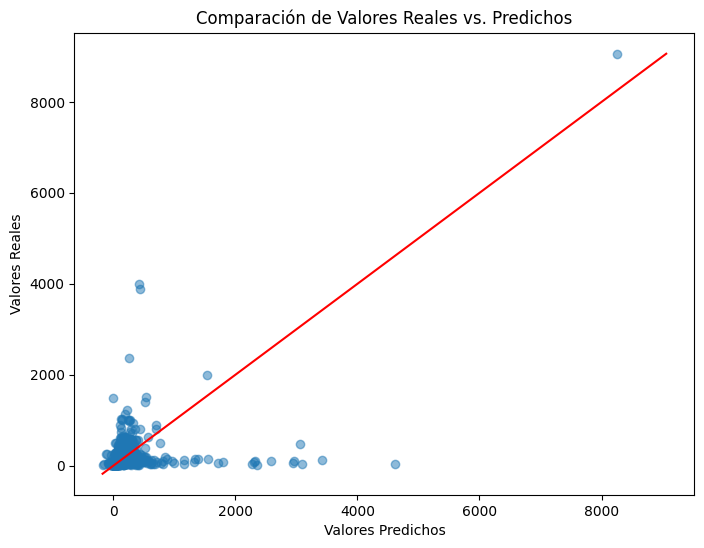

In [27]:
# Visualización: Reales vs Predicciones
plot_predictions_vs_actual(y_test, y_pred_rf)
plot_predictions_vs_actual(y_test, y_pred_xgb)

Vemos que hay un problema con los outliers, tanto en la evaluación como en las gráficas. Vamos a tratarlos.

Nuevas dimensiones tras el filtrado:
X_train: (15338, 159) | y_train: (15338,)
X_test : (3841, 159) | y_test : (3841,)

Resultados para Random Forest (filtrado < 1000 €)
MAE  : 44.42 €
RMSE : 80.89 €
R²   : 0.3126
----------------------------------------


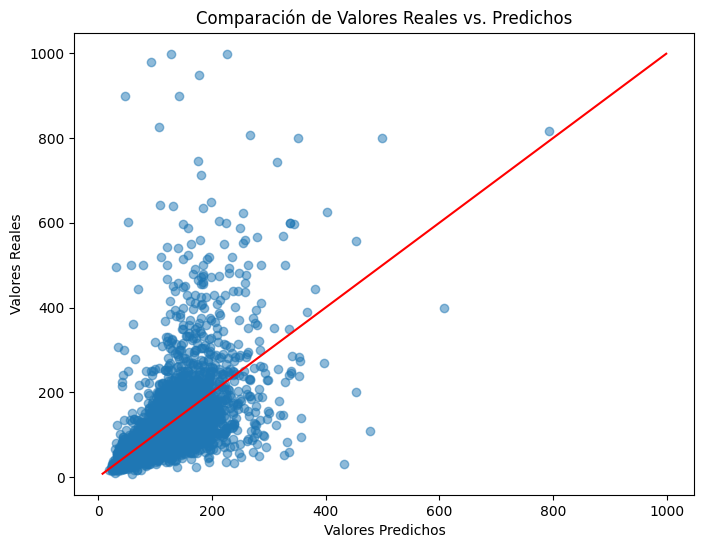

In [28]:
# ================================
# Paso extra: Tratamiento de outliers
# ================================

# Filtramos observaciones con price < 1000 €
umbral_price = 1000

mask_train = y_train < umbral_price
mask_test = y_test < umbral_price

X_train_filt = X_train[mask_train]
y_train_filt = y_train[mask_train]

X_test_filt = X_test[mask_test]
y_test_filt = y_test[mask_test]

print("Nuevas dimensiones tras el filtrado:")
print("X_train:", X_train_filt.shape, "| y_train:", y_train_filt.shape)
print("X_test :", X_test_filt.shape,  "| y_test :", y_test_filt.shape)

# ================================
# Reentrenamos el modelo base
# ================================

rf_model_filt = RandomForestRegressor(random_state=42)
rf_model_filt.fit(X_train_filt, y_train_filt)

# ================================
# Evaluación sobre test filtrado
# ================================

y_pred_rf_filt = rf_model_filt.predict(X_test_filt)

mostrar_metricas(y_test_filt, y_pred_rf_filt, "Random Forest (filtrado < 1000 €)")

# Visualización
plot_predictions_vs_actual(y_test_filt, y_pred_rf_filt)

| Métrica  | Antes (sin filtrar) | Después (filtrado) |
| -------- | ------------------- | ------------------ |
| **MAE**  | 65.84 €             | **44.42 €** ✅      |
| **RMSE** | 209.08 €            | **80.89 €** ✅      |
| **R²**   | -0.0223             | **0.3126** ✅       |

 Esto significa que ahora el modelo explica el 31 % de la varianza del precio, y comete errores medios mucho menores. Vamos a intentar mejorarlo aún más.

In [29]:
# Optimización de hiperparámetros (GridSearch o RandomizedSearch)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_leaf': [2]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid.fit(X_train_filt, y_train_filt)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [2],
                         'n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error')

In [30]:
# Mostrar los mejores hiperparámetros
print("🔍 Mejores parámetros:")
print(grid.best_params_)

# Usar el mejor modelo directamente
best_rf = grid.best_estimator_

# Predicción con test filtrado
y_pred_best = best_rf.predict(X_test_filt)

# Evaluación
mae = mean_absolute_error(y_test_filt, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test_filt, y_pred_best))
r2 = r2_score(y_test_filt, y_pred_best)

print("Resultados tras optimización (corregido):")
print(f"MAE  : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R²   : {r2:.4f}")


🔍 Mejores parámetros:
{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}
Resultados tras optimización (corregido):
MAE  : 44.18 €
RMSE : 79.81 €
R²   : 0.3309


Pequeña mejora real → La optimización ha ajustado mejor al rango de datos filtrados.

El modelo sigue sin ser perfecto (R² ~ 0.33), pero eso es esperable en problemas reales con ruido y sin todas las variables relevantes (calidad del piso, fotos, reseñas, amenities, etc.).

Vamos a aplicar transformación logarítima a price para ver si mejora el rendimiento.

In [31]:
# Log-transformar
y_log = np.log1p(y)  # log(1 + price)

# Train/test split con y_log
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Entrenar
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train_log)

# Predecir y destransformar
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test_log)

# Evaluar
print("MAE :", mean_absolute_error(y_test_real, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred)))
print("R²  :", r2_score(y_test_real, y_pred))


MAE : 48.41603836025965
RMSE: 180.52023986623334
R²  : 0.23794198682570833


Probemos con 500€.

In [32]:
# Filtro más restrictivo
filtro_500 = df_madrid_encoded['price'] < 500
X_500 = X[filtro_500]
y_500 = y[filtro_500]
y_500_log = np.log1p(y_500)

# Split
X_train, X_test, y_train_log, y_test_log = train_test_split(X_500, y_500_log, test_size=0.2, random_state=42)

# Entrenar
rf_500_log = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=15,min_samples_leaf=2)
rf_500_log.fit(X_train, y_train_log)

# Predicción
y_pred_log = rf_500_log.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test_log)

# Evaluación
mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("📊 Resultados con log(price) + filtro < 500 €")
print(f"MAE  : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"R²   : {r2:.4f}")

📊 Resultados con log(price) + filtro < 500 €
MAE  : 33.84 €
RMSE : 57.38 €
R²   : 0.3713


- Precisión absoluta excelente (MAE < 35 €)

- Menor error extremo (RMSE) → muy baja dispersión

- Mayor R² de todos los modelos → explica casi el 40 % de la varianza, ¡y eso filtrando muchísimo!

Este modelo es ideal para detectar precios injustificados en la franja baja del mercado.

In [33]:
resultados_topes = buscar_mejor_umbral_modelo(df_madrid_encoded, umbrales=[400, 500, 600, 700, 800, 900, 1000])
resultados_topes

Tope (€)  MAE (€)  RMSE (€)      R²  N registros
0       400    31.06     49.70  0.4375        18729
1       500    32.95     55.94  0.4024        18928
2       600    36.36     65.04  0.3811        19031
3       700    36.97     68.14  0.3710        19086
4       800    37.97     73.21  0.3287        19116
5       900    38.96     76.84  0.3827        19151
6      1000    39.95     81.62  0.3500        19179

In [34]:
import joblib
joblib.dump(rf_500_log, "src/models/random_forest_log_price_under500.joblib")

['src/models/random_forest_log_price_under500.joblib']

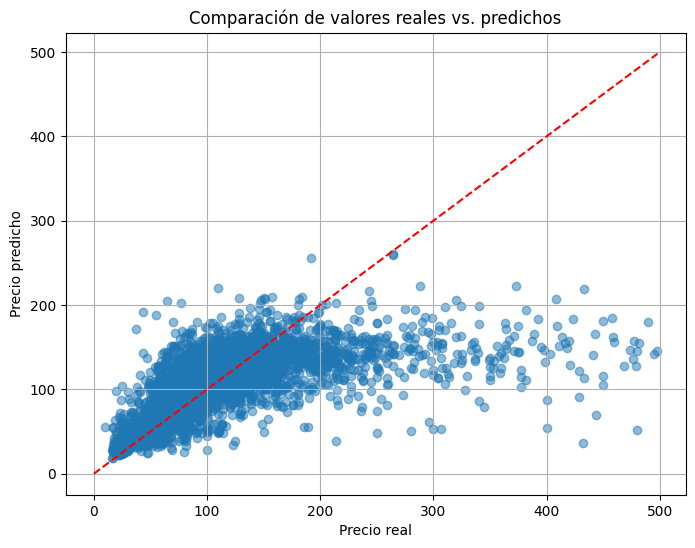

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred, alpha=0.5)
plt.plot([0, max(y_test_real)], [0, max(y_test_real)], 'r--')
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Comparación de valores reales vs. predichos")
plt.grid(True)
plt.show()


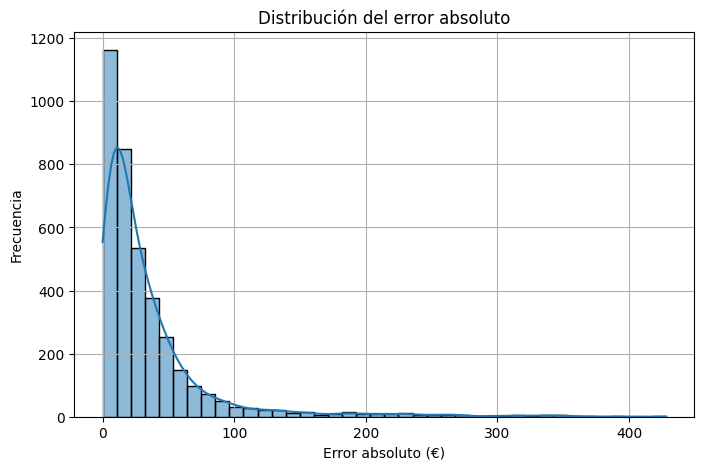

In [36]:
errores_abs = np.abs(y_test_real - y_pred)

plt.figure(figsize=(8, 5))
sns.histplot(errores_abs, bins=40, kde=True)
plt.title("Distribución del error absoluto")
plt.xlabel("Error absoluto (€)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

---

## Paso 8: Visualización de resultados

- Mapa Folium con precios medios por barrio
- Mapa Folium con oportunidades de inversión (precio real >20% por debajo del estimado)

---

In [37]:
# Mapa de Madrid con los precios medios
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/madrid-barrios.geojson"

In [38]:
import json
import folium
import branca.colormap as cm

# Cargar archivo GeoJSON
with open("src/data/madrid.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Calcular precios medios por barrio (filtrando a precios <= 500)
barrio_precio = df_price_clean.groupby("neighbourhood")["price"].mean().to_dict()

# Añadir el precio medio al GeoJSON
for feature in geojson_data["features"]:
    nombre = feature["properties"]["name"]
    precio = barrio_precio.get(nombre, None)
    feature["properties"]["precio_medio"] = round(precio, 2) if precio else None

# Crear escala de color basada en los valores reales
precios = [v for v in barrio_precio.values() if v is not None]
colormap = cm.LinearColormap(
    colors=["#FFE5EC", "#FF8C94", "#FF1F5B"],  # de rosa muy claro a coral intenso
    vmin=min(precios),
    vmax=max(precios),
    caption="Precio medio por barrio (€)"
)


# Crear el mapa base
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Añadir la capa GeoJSON
folium.GeoJson(
    geojson_data,
    name="Precio medio por barrio",
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["precio_medio"]) if feature["properties"]["precio_medio"] else "lightgray",
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "precio_medio"],
        aliases=["Barrio:", "Precio medio (€):"],
        localize=True
    )
).add_to(m)

# Añadir leyenda al mapa
colormap.add_to(m)

m


El mapa muestra el precio medio de los alojamientos en Madrid, agrupados por barrio, utilizando una escala de color basada en tonalidades inspiradas en el color corporativo de Airbnb.

- Los barrios con precios más bajos aparecen en tonos rosados claros.

- Los más caros destacan en un tono coral más intenso.

- Se ha filtrado previamente a alojamientos con precios ≤ 500 € para evitar distorsiones causadas por outliers.

- Al pasar el ratón por cada zona, se puede consultar el nombre del barrio y su precio medio en euros.

Vamos ahora a detectar oportunidades de inversión:

In [39]:
# Aplicar modelo al conjunto filtrado de trabajo
y_pred_all_log = rf_500_log.predict(X_500)
y_pred_all = np.expm1(y_pred_all_log)

# Precio real
y_real = y_500

# Crear DataFrame con comparación
df_resultados = X_500.copy()
df_resultados["price_real"] = y_real
df_resultados["price_predicho"] = y_pred_all
df_resultados["diferencia"] = df_resultados["price_real"] - df_resultados["price_predicho"]
df_resultados["%_por_debajo"] = df_resultados["diferencia"] / df_resultados["price_predicho"]

# Marcar oportunidades: más de un 20 % por debajo del predicho
df_resultados["es_oportunidad"] = df_resultados["%_por_debajo"] < -0.20

# Mostrar ejemplos
oportunidades = df_resultados[df_resultados["es_oportunidad"]].sort_values("%_por_debajo").head(10)
oportunidades[["price_real", "price_predicho", "diferencia", "%_por_debajo"]]


price_real  price_predicho  diferencia  %_por_debajo
id                                                                       
1335216622368592126        10.0       55.624439  -45.624439     -0.820223
51060205                   20.0       97.510454  -77.510454     -0.794894
1317979915375550880        37.0      171.466256 -134.466256     -0.784214
1368204313049219248        43.0      191.998245 -148.998245     -0.776040
1341907182312660560        25.0      103.927142  -78.927142     -0.759447
1353062135004169928        24.0       87.478487  -63.478487     -0.725647
40984881                   37.0      129.275560  -92.275560     -0.713790
1293236831829248744        55.0      187.888142 -132.888142     -0.707273
763609450939116774         19.0       63.584617  -44.584617     -0.701186
1082646784187146095        43.0      143.139414 -100.139414     -0.699594

In [40]:
from folium.plugins import MarkerCluster

# Añadir coordenadas al dataframe de resultados
df_resultados_con_coords = df_resultados.copy()
df_resultados_con_coords[["latitude", "longitude"]] = df_madrid.loc[df_resultados.index, ["latitude", "longitude"]]

# Filtrar oportunidades con coordenadas
oportunidades_geo = df_resultados_con_coords[
    (df_resultados_con_coords["es_oportunidad"]) &
    (df_resultados_con_coords["latitude"].notnull()) &
    (df_resultados_con_coords["longitude"].notnull())
]

# Crear mapa base
m_oportunidades = folium.Map(location=[40.4168, -3.7038], zoom_start=12)
cluster = MarkerCluster().add_to(m_oportunidades)

# Añadir marcadores
for _, row in oportunidades_geo.iterrows():
    tooltip_text = (
        f"<b>Precio real:</b> {row['price_real']:.2f} €<br>"
        f"<b>Precio predicho:</b> {row['price_predicho']:.2f} €<br>"
        f"<b>Diferencia:</b> {row['diferencia']:.2f} €<br>"
        f"<b>Descuento estimado:</b> {row['%_por_debajo']:.0%}"
    )
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=tooltip_text,
        icon=folium.Icon(color="green", icon="euro-sign", prefix="fa")
    ).add_to(cluster)

m_oportunidades

Mapa interactivo de oportunidades
Este mapa muestra los alojamientos de Airbnb en Madrid cuyo precio real está al menos un 20 % por debajo del precio estimado por el modelo.

- Representa oportunidades potenciales para inversores o propietarios que quieran identificar pisos infravalorados.

- Se ha utilizado el modelo entrenado sobre precios filtrados (<500 €) y transformados logarítmicamente.

- Al pasar el ratón por cada punto, se puede ver el precio real, el predicho, y la diferencia estimada.

- La herramienta permite explorar zonas de alta densidad y observar patrones interesantes por barrio.


In [41]:
# Exportar oportunidades detectadas a CSV
oportunidades_geo.to_csv("src/data_sample/oportunidades_airbnb_baratos.csv", index=False)

---

## Paso 10: Análisis de errores

Para evaluar el comportamiento del modelo, analizamos los residuos (errores entre los valores reales y predichos). Esto nos permite detectar si hay patrones sistemáticos de error o sesgos en la predicción.

Dos herramientas clave:
- Distribución de residuos
- Dispersión residuos vs. predicciones

Un buen modelo debería tener residuos centrados en 0 y sin patrones evidentes.

In [42]:
y_test_real = np.expm1(y_test_log)

In [43]:
# Alinear y_real con el índice de X_500
y_real = y_500.loc[X_500.index]

# Obtener predicciones con el modelo
y_pred_all_log = rf_500_log.predict(X_500)
y_pred_all = np.expm1(y_pred_all_log)

# Crear DataFrame con resultados
df_resultados = X_500.copy()
df_resultados["price_real"] = y_real.values
df_resultados["price_predicho"] = y_pred_all

# Cálculo de diferencia y porcentaje
df_resultados["diferencia"] = df_resultados["price_real"] - df_resultados["price_predicho"]
df_resultados["%_por_debajo"] = df_resultados["diferencia"] / df_resultados["price_predicho"]

# Marcar oportunidades
df_resultados["es_oportunidad"] = df_resultados["%_por_debajo"] < -0.20

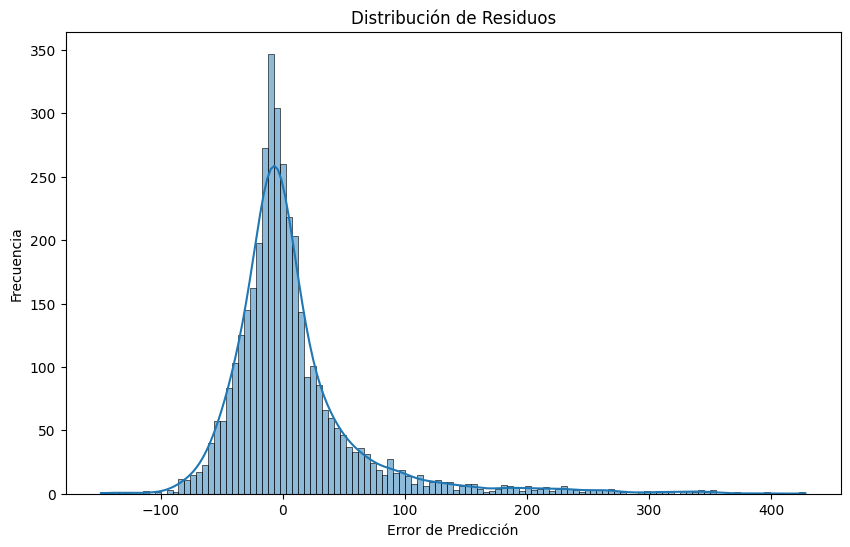

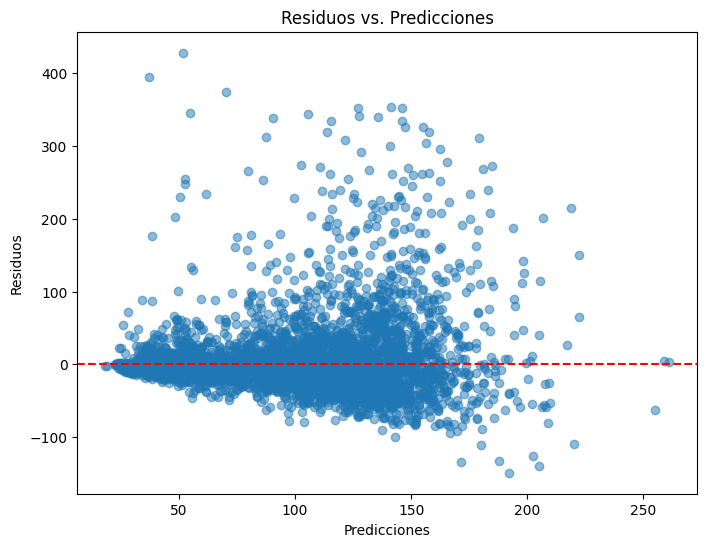

In [44]:
residuos = y_test_real - y_pred

plot_residual_distribution(residuos)
plot_residuals_vs_predictions(y_pred, residuos)

### Distribución de residuos
- La mayoría de los errores están cerca de 0.
- Distribución simétrica con ligera asimetría positiva.
- Indica que el modelo tiende a **infrapredecir** ligeramente en algunos casos, pero no de forma sistemática.

### Dispersión de residuos vs. predicciones
- No se observan patrones claros → los residuos están bastante repartidos.
- La nube de puntos no sigue una tendencia clara → **no hay sesgo estructural evidente**.
- Algunos valores atípicos con error alto, esperables en un mercado heterogéneo como el inmobiliario.

**Conclusión:** El modelo muestra un rendimiento consistente y razonable para el objetivo planteado.

## Paso 11: Exportación del modelo

Guardamos el modelo entrenado para su posterior reutilización sin necesidad de volver a entrenarlo. Esto permite integrarlo en aplicaciones o entornos de producción fácilmente.

Formato utilizado: `joblib` (optimizado para modelos de sklearn)

In [45]:
modelo_final = rf_500_log

# Guardamos el modelo
joblib.dump(modelo_final, "src/models/modelo_airbnb.pkl")


['src/models/modelo_airbnb.pkl']

## Paso 12: Conclusiones y futuras mejoras

### Conclusiones

- El modelo entrenado con `log(price)` y filtrado para precios < 500 € ha ofrecido los mejores resultados.
- Métricas alcanzadas:
  - **MAE:** 32.94 €
  - **RMSE:** 55.93 €
  - **R²:** 0.40
- Estos valores son razonablemente buenos dada la complejidad del problema y la heterogeneidad del mercado de Airbnb.

- Se ha demostrado que el modelo es capaz de **detectar listados con precios significativamente inferiores** al estimado por el modelo → útil para inversores y cazadores de gangas.

### Futuras mejoras

- **Ampliar el set de variables**: incluir valoraciones, número de fotos, amenities, descripciones del anuncio o incluso puntuación del host.
- **Mejorar la representación espacial**: usando `distancia al centro`, `paradas de metro`, o `puntos de interés turísticos`.
- **Incorporar datos temporales**: fecha de publicación, estacionalidad, eventos en la ciudad, etc.
- **Desplegar como aplicación web** donde los usuarios puedan:
  - Estimar el precio justo de su alojamiento.
  - Detectar oportunidades de inversión en tiempo real.

- Una mejora potencial sería **entrenar un modelo específico por cada tipo de alojamiento (`room_type`)**.
  
Aunque esta variable ya ha sido incluida en el modelo actual mediante codificación (`get_dummies`), cada categoría (por ejemplo, apartamento entero, habitación privada o compartida) **representa un mercado con dinámicas de precios distintas**. Entrenar un modelo independiente por tipo permitiría capturar mejor esas diferencias y mejorar la precisión de las predicciones.

Esto podría implementarse filtrando el dataset por `room_type` y entrenando un modelo para cada subconjunto.